### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [2072]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2422]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        
      
        def F(y_):
            classes = np.unique(y_)
            a = np.bincount(y_, minlength = classes[-1])/y_.shape[0]
            if self.criterion == 'gini':
                res = 1 - np.dot(a,a)        
            elif self.criterion == 'H':
                a = a[a>0]
                res = - np.dot(a, np.log(a))
            elif self.criterion == 'classification_err':
                res = 1 - np.max(a)
            return res
        
        #Rl- обьекты которые пойдут влево, Rr - вправо
        Qmax = 0 
        max_f_id = 0
        max_threshold = 0
        f = 1
        for feature_id in range(x.shape[1]):
            ths = np.unique(x[:,feature_id])
            for threshold in ths[0:-1]:
                left_mask = x[:, feature_id] > threshold
                right_mask = ~left_mask
                yl = y[left_mask]
                yr = y[right_mask]
                Nl = yl.shape[0]
                Nr = yr.shape[0]
                Nm = y.shape[0]
                Q = f - (Nl*F(yl) + Nr*F(yr))/Nm
                if(Q > Qmax):
                    Qmax = Q
                    max_f_id = feature_id
                    max_threshold = threshold
                    
                    
        return  max_f_id, max_threshold
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        
        un = np.unique(y).size
        if un == 1:
            class_pred = y[0]
            class_proba = 1
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        elif y.shape[0] < self.min_samples_split or depth == self.max_depth:
            counts = np.bincount(y, minlength = un)
            # print("y",y)
            class_pred = np.argmax(counts)
           # print(class_pred)
            class_proba = counts[class_pred]/(y.shape[0])
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        else:
            # print("here y",y)
            feature_id, threshold = self.__find_threshold(x, y)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            self.tree[node_id] = ['NON_LEAF_TYPE', feature_id, threshold]
            if xl.shape[0]:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
            if xr.shape[0]:
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)

                
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.classes = np.unique(y)
        self.num_class = self.classes.size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        # print("node", node)
        if node[0] == "NON_LEAF_TYPE":
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance():
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        pass

In [2371]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'gini')
clf = DecisionTreeClassifier(min_samples_split=2)

In [2140]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [2141]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [2142]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [2143]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [2144]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'classification_err')
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [2145]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'H')
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

In [2146]:
acc = []
my_acc = []
for i in range(10):
    wine = load_wine()
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    acc.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    my_acc.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
print(sum(acc)/len(acc), sum(my_acc)/len(my_acc))

0.9111111111111112 0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [2428]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = {}
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
       
        max_f_id = 0
        max_threshold = 0
        if self.criterion == 'gini':
            Qmax = np.Inf
            un = np.unique(y)
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in un])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                left_total = np.arange(1, len(y)+1)
                right_total = np.arange(len(y)-1, -1, -1)
                left = np.sum(classes_left[:-1,:].T[:,-1::-1]*np.cumsum(classes_left[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right = np.sum(classes_right[:-1,:].T[:,-1::-1]*np.cumsum(classes_right[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right_total[-1] = 1
                gini = left/left_total + right/right_total
                min_ths_ind = np.argmin(gini)
                Q = gini[min_ths_ind]
                if Qmax > Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id                

                    
        elif self.criterion == 'classification_err':
            Qmax = 0
            un = np.unique(y)  
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in np.unique(y)])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                err = np.max(classes_left, axis = 0) + np.max(classes_right, axis = 0)
                #print(classes_left, np.max(classes_left, axis = 1))
                min_ths_ind = np.argmax(err)
                Q = err[min_ths_ind]
                if Qmax < Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id
                    
        else:
            Qmax = -np.Inf
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in np.unique(y)])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                left_total = np.arange(1, len(y)+1)
                right_total = np.arange(len(y)-1, -1, -1)
                lg = classes_left.T
                lg[np.where(lg==0)] = 1
                lt = left_total
                lt[np.where(lt==0)] = 1
                left = np.sum(classes_left.T * np.log(lg),axis = 1) - left_total * np.log(lt)
                lg = classes_right.T
                lg[np.where(lg==0)] = 1
                rt = right_total
                rt[np.where(rt==0)] = 1
                right = np.sum(classes_right.T * np.log(lg),axis = 1) - right_total * np.log(rt)
                H = left + right
                min_ths_ind = np.argmax(H)
                Q = H[min_ths_ind]
                if Qmax < Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id   
                   
        return  max_f_id, max_threshold
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        
        un = np.unique(y).size
        if un == 1:
            class_pred = y[0]
            class_proba = 1
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        elif y.shape[0] < self.min_samples_split or depth == self.max_depth:
            counts = np.bincount(y, minlength = un)
            class_pred = np.argmax(counts)
            class_proba = counts[class_pred]/(y.shape[0])
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if xl.shape[0] and xr.shape[0]:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
                self.tree[node_id] = ['NON_LEAF_TYPE', feature_id, threshold]
            else:
                counts = np.bincount(y, minlength = un)
                class_pred = np.argmax(counts)
                class_proba = counts[class_pred]/(y.shape[0])
                self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
               
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.classes = np.unique(y)
        self.num_class = self.classes.size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        # print("node", node)
        if node[0] == "NON_LEAF_TYPE":
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        pass

In [2234]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'gini')
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [2235]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [2236]:
%time my_clf.fit(X_train, y_train)

Wall time: 12.1 ms


In [2237]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8333333333333334

In [2238]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.9444444444444444

In [2239]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'H')
%time my_clf.fit(X_train, y_train)

Wall time: 19.4 ms


In [2240]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

In [2243]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'classification_err')
%time my_clf.fit(X_train, y_train)


Wall time: 15.5 ms


In [2244]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [2299]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [2300]:
df = df.iloc[:, :97]
df

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1
0,1,1.0,0,1,1,1,10,7,NaN,4,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0


In [2301]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

In [2302]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [2303]:
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)

In [2304]:
df = df.drop(['position', 'positin1'], axis=1)

In [2305]:
df = df.drop(['order'], axis=1)

In [2306]:
df = df.drop(['partner'], axis=1)

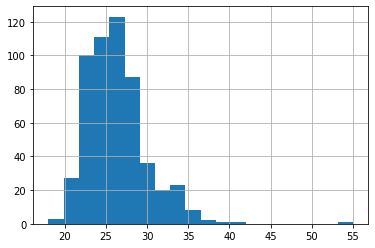

In [2307]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [2308]:
df.drop_duplicates('iid').age.isnull().sum()

8

In [2309]:
df = df.dropna(subset=['age'])

In [2310]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())
df.field_cd.isnull().sum()
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [2311]:
df = df.drop(['undergra'], axis=1)

In [2312]:
df.mn_sat.value_counts().head()

1,400.00    403
1,430.00    262
1,290.00    190
1,450.00    163
1,340.00    146
Name: mn_sat, dtype: int64

342

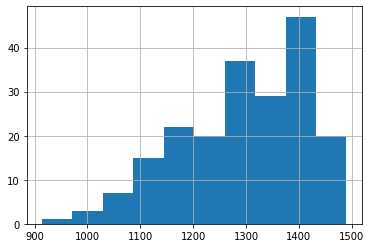

In [2313]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').mn_sat.hist()
df.drop_duplicates('iid').mn_sat.isnull().sum()

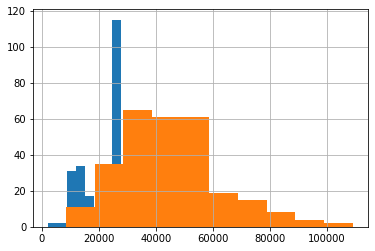

In [2314]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').tuition.hist()
df.drop_duplicates('iid').tuition.isnull().sum()
df.drop_duplicates('iid').imprace.isnull().sum()
df.drop_duplicates('iid').imprelig.isnull().sum()
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [2315]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()
df = df.drop(['income'], axis=1)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)
df = df.drop(['expnum'], axis=1)

In [2316]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [2317]:

feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

temp.loc[idx, ]

idx = ((temp.wave >= 6) & (temp.wave <= 9))

temp.loc[idx, ]

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)

In [2318]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [2319]:
df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()


In [2321]:
df_male

,iid,pid,match,int_corr,samerace,age,field_cd,mn_sat,tuition,race,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
3489,243,234.0,0,0.43,0,27.0,16.0,1450.0,26100.0,2.0,...,25.0,15.0,20.0,10.0,10.0,7.0,9.0,8.0,9.0,5.0
3490,243,235.0,1,0.33,1,27.0,16.0,1450.0,26100.0,2.0,...,25.0,15.0,20.0,10.0,10.0,7.0,9.0,8.0,9.0,5.0
3491,243,236.0,0,0.06,0,27.0,16.0,1450.0,26100.0,2.0,...,25.0,15.0,20.0,10.0,10.0,7.0,9.0,8.0,9.0,5.0
3492,243,237.0,0,0.38,1,27.0,16.0,1450.0,26100.0,2.0,...,25.0,15.0,20.0,10.0,10.0,7.0,9.0,8.0,9.0,5.0
3493,243,238.0,0,0.28,1,27.0,16.0,1450.0,26100.0,2.0,...,25.0,15.0,20.0,10.0,10.0,7.0,9.0,8.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8351,551,526.0,0,0.41,0,27.0,8.0,1400.0,26019.0,1.0,...,0.0,0.0,40.0,0.0,0.0,7.0,8.0,3.0,8.0,5.0
8352,551,527.0,0,0.29,0,27.0,8.0,1400.0,26019.0,1.0,...,0.0,0.0,40.0,0.0,0.0,7.0,8.0,3.0,8.0,5.0
8353,551,528.0,0,-0.55,0,27.0,8.0,1400.0,26019.0,1.0,...,0.0,0.0,40.0,0.0,0.0,7.0,8.0,3.0,8.0,5.0
8354,551,529.0,0,0.09,0,27.0,8.0,1400.0,26019.0,1.0,...,0.0,0.0,40.0,0.0,0.0,7.0,8.0,3.0,8.0,5.0


In [2322]:
df_female

,iid,pid,age,field_cd,mn_sat,tuition,race,imprace,imprelig,goal,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
3408,234,243.0,22.0,3.0,1070.0,12696.0,6.0,1.0,5.0,3.0,...,1.0,1.0,3.0,10.0,10.0,7.0,7.0,8.0,8.0,10.0
3417,235,243.0,23.0,9.0,1258.0,25020.0,2.0,3.0,1.0,1.0,...,10.0,10.0,25.0,10.0,20.0,6.0,9.0,9.0,8.0,9.0
3426,236,243.0,24.0,10.0,1400.0,26630.0,4.0,3.0,3.0,2.0,...,10.0,10.0,30.0,10.0,10.0,7.0,9.0,10.0,8.0,8.0
3435,237,243.0,34.0,7.0,1290.0,15309.0,2.0,10.0,1.0,3.0,...,5.0,15.0,30.0,10.0,10.0,8.0,10.0,7.0,8.0,8.0
3444,238,243.0,27.0,15.0,1460.0,26376.0,2.0,3.0,5.0,1.0,...,10.0,10.0,25.0,0.0,5.0,10.0,9.0,10.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7740,524,531.0,25.0,4.0,1430.0,26908.0,4.0,9.0,6.0,2.0,...,10.0,15.0,20.0,10.0,10.0,5.0,9.0,7.0,8.0,7.0
7762,525,531.0,24.0,15.0,1360.0,26062.0,2.0,2.0,8.0,2.0,...,5.0,5.0,25.0,5.0,10.0,6.0,10.0,8.0,10.0,9.0
7784,526,531.0,26.0,11.0,1188.0,11311.0,3.0,5.0,2.0,1.0,...,10.0,10.0,10.0,10.0,10.0,3.0,6.0,9.0,7.0,10.0
7806,527,531.0,24.0,11.0,1290.0,15309.0,6.0,5.0,5.0,1.0,...,5.0,5.0,5.0,10.0,5.0,10.0,10.0,10.0,10.0,10.0


In [2324]:
df_male.join(df_female, on = 'pid' ,rsuffix='f_', how = 'left')

,iid,pid,match,int_corr,samerace,age,field_cd,mn_sat,tuition,race,...,sinc2_1f_,intel2_1f_,fun2_1f_,amb2_1f_,shar2_1f_,attr3_1f_,sinc3_1f_,fun3_1f_,intel3_1f_,amb3_1f_
3489,243,234.0,0,0.43,0,27.0,16.0,1450.0,26100.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3490,243,235.0,1,0.33,1,27.0,16.0,1450.0,26100.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3491,243,236.0,0,0.06,0,27.0,16.0,1450.0,26100.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3492,243,237.0,0,0.38,1,27.0,16.0,1450.0,26100.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3493,243,238.0,0,0.28,1,27.0,16.0,1450.0,26100.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8351,551,526.0,0,0.41,0,27.0,8.0,1400.0,26019.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8352,551,527.0,0,0.29,0,27.0,8.0,1400.0,26019.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8353,551,528.0,0,-0.55,0,27.0,8.0,1400.0,26019.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8354,551,529.0,0,0.09,0,27.0,8.0,1400.0,26019.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [2524]:
x = np.asarray(df_male.join(df_female, on = 'pid' ,rsuffix='f_', how = 'left'))
x.shape
x
my_clf = MyDecisionTreeClassifier(max_depth = 5, criterion = 'classification_err')

In [2531]:
x[np.isnan(x)] = 0
xtrain = x[:1000,3:]
y = np.asarray(x[:,2],dtype = 'int64')
ytrain = y[:1000]
xtest = x[1000:,3:]
ytest = y[1000:] 
my_clf.fit(xtrain, ytrain)
accuracy_score(y_pred=my_clf.predict(xtest), y_true=ytest)

0.8779342723004695

In [2532]:
import sklearn
sklearn.metrics.f1_score(ytest,my_clf.predict(xtest))


0.13333333333333333

In [2533]:
# обновленный для вызова feature_importance код ниже
my_clf.get_feature_importance()

{6: 8, 0: 26, 26: 8, 18: 12, 9: 4, 10: 12, 1: 8, 25: 4, 3: 2, 14: 4}

In [2534]:
clf.fit(xtrain,ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [2535]:
sklearn.metrics.f1_score(ytest,clf.predict(xtest))

0.10714285714285714

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [2523]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini', feature_importance = True):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = {}
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.feature_importance = feature_importance

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
       
        max_f_id = 0
        max_threshold = 0
        if self.criterion == 'gini':
            Qmax = np.Inf
            un = np.unique(y)
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in un])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                left_total = np.arange(1, len(y)+1)
                right_total = np.arange(len(y)-1, -1, -1)
                left = np.sum(classes_left[:-1,:].T[:,-1::-1]*np.cumsum(classes_left[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right = np.sum(classes_right[:-1,:].T[:,-1::-1]*np.cumsum(classes_right[1:,:].T[:,-1::-1],axis = 1),axis = 1)
                right_total[-1] = 1
                gini = left/left_total + right/right_total
                min_ths_ind = np.argmin(gini)
                Q = gini[min_ths_ind]
                if Qmax > Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id                
            if self.feature_importance:
                f = np.bincount(y, minlength = un.size)
                F = y.shape[0] - np.dot(f,f)/y.shape[0]
                if max_f_id not in self.feature_importances_:
                    self.feature_importances_[max_f_id] = F - Qmax 
                else:
                    self.feature_importances_[max_f_id] += F - Qmax

                    
        elif self.criterion == 'classification_err':
            Qmax = 0
            un = np.unique(y)
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in np.unique(y)])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                err = np.max(classes_left, axis = 0) + np.max(classes_right, axis = 0)
                #print(classes_left, np.max(classes_left, axis = 1))
                min_ths_ind = np.argmax(err)
                Q = err[min_ths_ind]
                if Qmax < Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id
            if self.feature_importance:
                f = np.bincount(y, minlength = un.size)
                F = - np.max(f)
                if max_f_id not in self.feature_importances_:
                    self.feature_importances_[max_f_id] = F + Qmax 
                else:
                    self.feature_importances_[max_f_id] += F + Qmax

                    
        else:
            Qmax = -np.Inf
            for feature_id in range(x.shape[1]):
                ind = np.argsort(x[:,feature_id])
                ord_classes = y[ind]
                classes_left = np.asarray([np.cumsum((ord_classes == k)) for k in np.unique(y)])
                classes_right = classes_left[:,-1].reshape(-1,1) - classes_left[:,:]
                left_total = np.arange(1, len(y)+1)
                right_total = np.arange(len(y)-1, -1, -1)
                lg = classes_left.T
                lg[np.where(lg==0)] = 1
                lt = left_total
                lt[np.where(lt==0)] = 1
                left = np.sum(classes_left.T * np.log(lg),axis = 1) - left_total * np.log(lt)
                lg = classes_right.T
                lg[np.where(lg==0)] = 1
                rt = right_total
                rt[np.where(rt==0)] = 1
                right = np.sum(classes_right.T * np.log(lg),axis = 1) - right_total * np.log(rt)
                H = left + right
                min_ths_ind = np.argmax(H)
                Q = H[min_ths_ind]
                if Qmax < Q:
                    Qmax = Q
                    index = np.argwhere(ind == min_ths_ind).item(0)
                    max_threshold = x[index, feature_id]
                    max_f_id = feature_id   
              
           
        
        return  max_f_id, max_threshold
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        
        un = np.unique(y).size
        if un == 1:
            class_pred = y[0]
            class_proba = 1
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        elif y.shape[0] < self.min_samples_split or depth == self.max_depth:
            counts = np.bincount(y, minlength = un)
            class_pred = np.argmax(counts)
            class_proba = counts[class_pred]/(y.shape[0])
            self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if xl.shape[0] and xr.shape[0]:
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
                self.tree[node_id] = ['NON_LEAF_TYPE', feature_id, threshold]
            else:
                counts = np.bincount(y, minlength = un)
                class_pred = np.argmax(counts)
                class_proba = counts[class_pred]/(y.shape[0])
                self.tree[node_id] = ['LEAF_TYPE', class_pred, class_proba]
               
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.classes = np.unique(y)
        self.num_class = self.classes.size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        # print("node", node)
        if node[0] == "NON_LEAF_TYPE":
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        if self.feature_importance:
            return self.feature_importances_

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [ ]:
# вышло не очень, но я честно старалась !!

In [2536]:
# непонятно, почему после перехода на нампай качество стало хуже, мб где то в формулах косяк, 
# но за несколько бессонных ночей выявить его так и не удалось
# не хватило времени, чтобы нормально разобраться и посмотреть на датасет, поэтому с ним вышла ерунда
# из пожеланий - чтобы поменьше заданий было в декабре, сессия все же :()
# в остальном все очень интересно и полезно, как и всегда